In [13]:
import kagglehub
import pandas as pd
import os
import cv2
import random
import matplotlib.pyplot as plt


In [14]:
distribution = [('train', 0.8), ('test', 0.1), ('val', 0.1)]

In [15]:
path = kagglehub.dataset_download("stanislavlevendeev/hazmat-detection")
video_directory = os.environ["PATH_TO_DATA"]
print("Path to dataset files:", path)
print("Path to video files:", video_directory)

100%|██████████| 2.17G/2.17G [05:22<00:00, 7.23MB/s]

Extracting files...


Path to dataset files: C:\Users\stani\.cache\kagglehub\datasets\stanislavlevendeev\hazmat-detection\versions\11
Path to video files: C:/Users/stani/Documents/WagonVideos


In [16]:
df = pd.read_csv(path + "/labels_dataframe.csv")
videos = df["Source"].unique()
videos

array(['1690279852.mp4', '1690281365.mp4', '1692830440.mp4',
       '1690801380.mp4', '1691487366.mp4', '1692787289.mp4',
       '1692875102.mp4', '1692945482.mp4', '1693811855.mp4',
       '1693954819.mp4', '1693805101.mp4', '1693820172.mp4',
       '1691496786.mp4', '1692872075.mp4', '1693308534.mp4',
       '1693308657.mp4', '1693309263.mp4', '1693820241.mp4',
       '1693820504.mp4', '1693820904.mp4', '1696009577.mp4',
       '1696374314.mp4', '1696416413.mp4', '1696441496.mp4'], dtype=object)

In [17]:
available_videos = os.listdir(video_directory)
available_videos = [video for video in available_videos if video.endswith(".mp4")]
available_videos = [video for video in available_videos if video in videos]
available_videos

['1690281365.mp4', '1692830440.mp4']

In [18]:
total_frames = df[df["Source"].isin(available_videos)]
total_frames = total_frames[["Source", "Frames"]].drop_duplicates()["Frames"].sum()
total_frames

np.int64(5698)

In [19]:
def createYOLODataAnnotation(
    path=None,
    label_name=None,
    classId=None,
    xtl=0.0,
    ytl=0.0,
    xbr=0.0,
    ybr=0.0,
    img_width=0,
    img_height=0,
):
    os.makedirs(path, exist_ok=True)
    if not classId or classId == 0:
        with open(os.path.join(path, label_name), "w") as f:
            f.write(f"")
        return

    x_center = (xtl + xbr) / 2 / img_width
    y_center = (ytl + ybr) / 2 / img_height
    width = (xbr - xtl) / img_width
    height = (ybr - ytl) / img_height

    with open(os.path.join(path, label_name), "w") as f:
        f.write(f"0 {x_center} {y_center} {width} {height}\n")


frames_dir = path + "/images/"
os.makedirs(frames_dir, exist_ok=True)


def saveFrame(video_name="", frame_num=0, frame=None, frames_dir=frames_dir):
    if frame is None:
        return
    frame_index = str(frame_num).zfill(5)
    frame_name = f"{video_name}_{frame_index}.jpg"
    cv2.imwrite(f"{frames_dir}/{frame_name}", frame)


dataset = 0
print(int(distribution[dataset][1]))
switch_frame = distribution[dataset][1] * total_frames.astype(int)
print(switch_frame)

0
4558.400000000001


In [20]:
frames_count = 0
labels_dir = os.path.join(path, "yolo", "labels", distribution[dataset][0])
frames_dir = os.path.join(path, "yolo", "images", distribution[dataset][0])
os.makedirs(labels_dir, exist_ok=True)
os.makedirs(frames_dir, exist_ok=True)
for row in available_videos:
    video_path = video_directory + "/" + row
    if os.path.exists(video_path) == False:
        print(f"File {video_path} not found")
        continue
    processed_source = row.split(".")[0]
    # Open video file
    cap = cv2.VideoCapture(video_path)
    number_of_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"File {video_path} has {number_of_frames} frames")
    lables = df[df["Source"] == row]
    # save each frame and .txt file with labels
    frame_idx = 0
    while frame_idx < number_of_frames:
        if frame_idx + frames_count >= switch_frame:
            dataset += 1
            switch_frame += distribution[dataset][1] * total_frames
            labels_dir = os.path.join(path, "yolo", "labels", distribution[dataset][0])
            frames_dir = os.path.join(path, "yolo", "images", distribution[dataset][0])
            os.makedirs(frames_dir, exist_ok=True)
            os.makedirs(labels_dir, exist_ok=True)
            print(f"Switched to {distribution[dataset][0]} dataset")
        ret, frame = cap.read()  # Read each frame
        img_height, img_width, _ = frame.shape
        img_height = int(img_height)
        img_width = int(img_width)
        if not ret:
            break  # End of video
        # Save frame
        saveFrame(processed_source, frame_idx, frame, frames_dir)
        frame_index = str(frame_idx).zfill(5)
        label_name = f"{processed_source}_{frame_index}.txt"

        row = lables[lables["Relative Frame"] == frame_idx]
        isObject = frame_idx in lables["Relative Frame"].values
        createYOLODataAnnotation(
            path=labels_dir,
            label_name=label_name,
            classId=1 if isObject else None,
            xtl=float(row["XTL"].values[0]) if isObject else 0,
            xbr=float(row["XBR"].values[0]) if isObject else 0,
            ytl=float(row["YTL"].values[0]) if isObject else 0,
            ybr=float(row["YBR"].values[0]) if isObject else 0,
            img_height=img_height,
            img_width=img_width,
        )
        frame_idx += 1
    frames_count += number_of_frames
    cap.release()

File C:/Users/stani/Documents/WagonVideos/1690281365.mp4 has 733 frames
File C:/Users/stani/Documents/WagonVideos/1692830440.mp4 has 4965 frames
Switched to test dataset
Switched to val dataset


Random image: C:\Users\stani\.cache\kagglehub\datasets\stanislavlevendeev\hazmat-detection\versions\11\yolo\images\train\1690281365_00228.jpg
['0 0.3278125 0.5426805555555556 0.08201041666666668 0.07604629629629629\n']


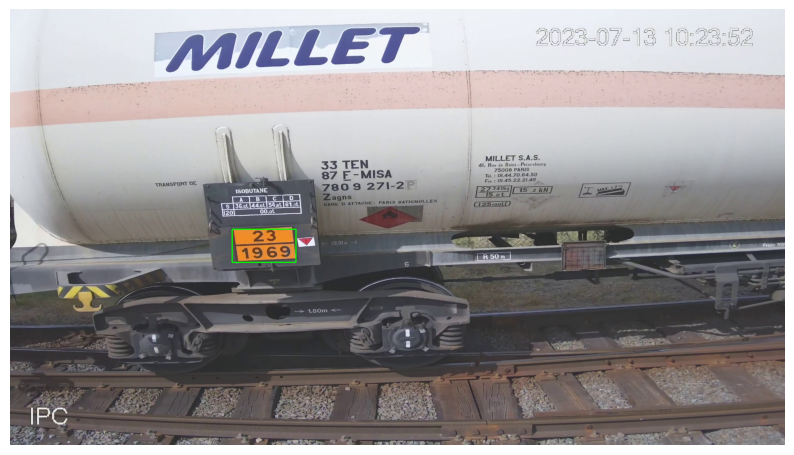

In [55]:

# Function to draw rectangles on an image
def draw_rectangles(image_path, annotation_path):
    # Read the image
    image = cv2.imread(image_path)
    img_height, img_width, _ = image.shape

    # Read the annotation file
    with open(annotation_path, "r") as f:
        lines = f.readlines()
        print(lines)
        for line in lines:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            # Convert from YOLO format to bounding box coordinates
            x_min = int((x_center - width / 2) * img_width)
            y_min = int((y_center - height / 2) * img_height)
            x_max = int((x_center + width / 2) * img_width)
            y_max = int((y_center + height / 2) * img_height)
            # Draw the rectangle
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    
    # Convert BGR image to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Display the image using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Directory containing images and annotations
image_dir = os.path.join(path, "yolo", "images", "train")
annotation_dir = os.path.join(path, "yolo", "labels", "train")

# Get a list of all images
images = total_frames = df[df["Source"].isin(available_videos)]

# Pick a random image
random_image = random.choice(images["Relative Frame"].values)
frame_info = images[images["Relative Frame"] == random_image]
image_path = os.path.join(image_dir, frame_info["Source"].values[0].replace('.mp4','') + "_" + str(random_image).zfill(5) + ".jpg")
print("Random image:", image_path)
# Corresponding annotation file
annotation_filename = frame_info["Source"].values[0].replace('.mp4','') + "_" + str(random_image).zfill(5) + ".txt"
annotation_path = os.path.join(annotation_dir, annotation_filename)

# Draw rectangles on the random image
draw_rectangles(image_path, annotation_path)